In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Green Suppliers

In [2]:
df_green = pd.read_csv('./관련자료/green.csv')
df_green.head()

,suppliers,energy_consumption,sales,co2_emission,R&D
0,S1,1267,119477,43562,67
1,S2,968,125762,45000,65
2,S3,1001,58770,42400,57
3,S4,1393,62989,43734,62
4,S5,1586,67088,44890,50


In [3]:
cols = df_green.columns[1:]
energy_option = {'type' : 'dae', 'max' : 1998, 'min' : 637, 'spread' : 50}
sales_option = {'type' : 'dae', 'max' : 125762, 'min' : 55681, 'spread' : 5000}
co2_option = {'type' : 'so', 'max' : 45023, 'min' : 3870, 'spread' : 500}
RnD_option = {'type' : 'dae', 'max' : 570, 'min' : 36, 'spread' : 0.5}

col_option = pd.DataFrame([energy_option, sales_option, co2_option, RnD_option])
col_option.index = cols
col_option

,type,max,min,spread
energy_consumption,dae,1998,637,50.0
sales,dae,125762,55681,5000.0
co2_emission,so,45023,3870,500.0
R&D,dae,570,36,0.5


In [4]:
def fuzzify_data(data):
    for col in data.columns:
        if col == 'suppliers':
            data_fuz = pd.DataFrame(data[col]).copy()
        else:
            spr = col_option.loc[col, 'spread']
            col_fuz = [(val-spr, val, val+spr) for val in data[col]]
            data_fuz[col] = col_fuz

    return data_fuz

df_fuz = fuzzify_data(df_green)
df_fuz.head()

,suppliers,energy_consumption,sales,co2_emission,R&D
0,S1,"(1217.0, 1267, 1317.0)","(114477.0, 119477, 124477.0)","(43062.0, 43562, 44062.0)","(66.5, 67, 67.5)"
1,S2,"(918.0, 968, 1018.0)","(120762.0, 125762, 130762.0)","(44500.0, 45000, 45500.0)","(64.5, 65, 65.5)"
2,S3,"(951.0, 1001, 1051.0)","(53770.0, 58770, 63770.0)","(41900.0, 42400, 42900.0)","(56.5, 57, 57.5)"
3,S4,"(1343.0, 1393, 1443.0)","(57989.0, 62989, 67989.0)","(43234.0, 43734, 44234.0)","(61.5, 62, 62.5)"
4,S5,"(1536.0, 1586, 1636.0)","(62088.0, 67088, 72088.0)","(44390.0, 44890, 45390.0)","(49.5, 50, 50.5)"


In [5]:
class model:
    def __init__(self):       
        pass    
    
    def col_score(self, inputs, col):
        y_i = inputs[col]

        max_idx = np.argmax(df_green[col])
        min_idx = np.argmin(df_green[col])
        
        y_max = df_fuz[col][max_idx]
        y_min = df_fuz[col][min_idx]
        
        bunja = self.fuz_sub(y_i, y_min)
        bunmo = self.fuz_sub(y_max, y_min)
        d_i = self.fuz_div(bunja, bunmo)
        
        col_type = col_option.loc[col, 'type']
        if col_type == 'dae':
            return np.array(d_i)
        elif col_type == 'so':
            return 1 - np.array(d_i)
        else:
            print('Type Error')

    def score(self, inputs):
        scores = 0
        for col in inputs.index:
            if col == 'suppliers':
                continue
            
            d = self.col_score(inputs, col)
            scores += np.array(d)
        
        return scores / (len(inputs) - 1)              
     
    def fuz_sub(self, num1, num2):
        left = num1[0] - num2[2]
        mid = num1[1] - num2[1]
        right = num1[2] - num2[0]
        return left, mid, right
    
    
    def fuz_div(self, num1, num2):
        cases = [a/b for a in [num1[0], num1[2]] for b in [num2[0], num2[2]]]
        left = min(cases)
        mid = num1[1] / num2[1]
        right = max(cases)
        return left, mid, right     

In [6]:
def round_fuz(number):
    return f'({number[0]:.3f}, {number[1]:.3f}, {number[2]:.3f})'

In [7]:
evaluation_model = model()

In [8]:
df_result = df_fuz.iloc[:, 0:1].copy()
results = []
for i, sup in df_fuz.iterrows():
    D = evaluation_model.score(sup)
    results.append(round_fuz(D))
    
df_result['score'] = results
df_result.head()

,suppliers,score
0,S1,"(0.389, 0.414, 0.442)"
1,S2,"(0.308, 0.325, 0.342)"
2,S3,"(0.181, 0.189, 0.185)"
3,S4,"(0.223, 0.227, 0.222)"
4,S5,"(0.227, 0.227, 0.218)"


In [9]:
def plot_tri(df, num=3):
    max_ = 0
    min_ = 1
    for idx in np.random.choice(df.index, num, replace=False):
        lab = df.loc[idx, 'suppliers']
        tri_num = df.loc[idx, 'score']
        left, mid, right = eval(tri_num)
        if left < min_:
            min_ = left
        if right > max_:
            max_ = right
        color = np.random.uniform(0, 1, 3)
        plt.plot([left, mid], [0, 1], color=color, label=lab)
        plt.plot([mid, right], [1, 0], color=color)

    plt.legend()
    plt.xlim(min_-0.1, max_+0.1)
    plt.ylim(0, 2)
    plt.show()

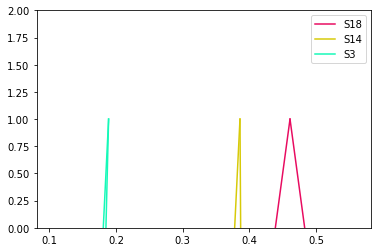

In [10]:
plot_tri(df_result)

### 나눗셈 2

사다리꼴 연산  
$ \tilde{X} = <l, X_1, X_2, r>, \tilde{Y} = <l, Y_1, Y_2, r> $

$$ \tilde{X}·\tilde{Y} ~=~ <l, \min \{ X_1 Y_1, X_1 Y_2, X_2 Y_1, X_2 Y_2 \}, \max \{ X_1 Y_1, X_1 Y_2, X_2 Y_1, X_2 Y_2 \}, r>  $$   
$$ \frac{\tilde{X}}{\tilde{Y}} ~=~ \tilde{X}·\frac{1}{\tilde{Y}}  $$  
$$ \left( \frac{1}{\tilde{Y}} ~=~ <l, \frac{1}{Y_2}, \frac{1}{Y_1} r> \right) $$

삼각형 버전   
$ \tilde{X} = <l, x, r>, \tilde{Y} = <l, y, r> $
  
$$ \tilde{X}·\tilde{Y} ~=~ <l, x·y, r> $$
$$ \frac{\tilde{X}}{\tilde{Y}} ~=~ \tilde{X}·\frac{1}{\tilde{Y}} $$
$$ \left( \frac{1}{\tilde{Y}} ~=~ <l, \frac{1}{y}, r> \right) $$
    
    
$$ \Rightarrow ~~~ \frac{\tilde{X}}{\tilde{Y}} ~=~ <l, \frac{x}{y}, r>  $$

In [11]:
class model2(model):
    def fuz_div(self, num1, num2):
        spread = num1[1] - num1[0]
        mid = num1[1] / num2[1]
        return mid - spread, mid, mid + spread

In [12]:
evaluation_model2 = model2()

In [13]:
df_result2 = df_fuz.iloc[:, 0:1].copy()
results = []
for i, sup in df_fuz.iterrows():
    D = evaluation_model2.score(sup)
    results.append(round_fuz(D))
    
df_result2['score'] = results
df_result2

,suppliers,score
0,S1,"(-2274.836, 0.414, 2275.664)"
1,S2,"(-2274.925, 0.325, 2275.575)"
2,S3,"(-2275.061, 0.189, 2275.439)"
3,S4,"(-2275.023, 0.227, 2275.477)"
4,S5,"(-2275.023, 0.227, 2275.477)"
5,S6,"(-2274.895, 0.355, 2275.605)"
6,S7,"(-2274.711, 0.539, 2275.789)"
7,S8,"(-2274.770, 0.480, 2275.730)"
8,S9,"(-2274.790, 0.460, 2275.710)"
9,S10,"(-2274.960, 0.290, 2275.540)"


In [14]:
# 고정 spread 수정
class model3(model):
    def fuz_div(self, num1, num2):
#         spread = num1[1] - num1[0]
        spread = 0.05
        mid = num1[1] / num2[1]
        return mid - spread, mid, mid + spread

In [15]:
evaluation_model3 = model3()

In [16]:
df_result3 = df_fuz.iloc[:, 0:1].copy()
results = []
for i, sup in df_fuz.iterrows():
    D = evaluation_model3.score(sup)
    results.append(round_fuz(D))
    
df_result3['score'] = results
df_result3.head()

,suppliers,score
0,S1,"(0.389, 0.414, 0.439)"
1,S2,"(0.300, 0.325, 0.350)"
2,S3,"(0.164, 0.189, 0.214)"
3,S4,"(0.202, 0.227, 0.252)"
4,S5,"(0.202, 0.227, 0.252)"


In [17]:
pd.concat([df_result, df_result3['score']], axis=1)

,suppliers,score,score
0,S1,"(0.389, 0.414, 0.442)","(0.389, 0.414, 0.439)"
1,S2,"(0.308, 0.325, 0.342)","(0.300, 0.325, 0.350)"
2,S3,"(0.181, 0.189, 0.185)","(0.164, 0.189, 0.214)"
3,S4,"(0.223, 0.227, 0.222)","(0.202, 0.227, 0.252)"
4,S5,"(0.227, 0.227, 0.218)","(0.202, 0.227, 0.252)"
5,S6,"(0.340, 0.355, 0.367)","(0.330, 0.355, 0.380)"
6,S7,"(0.504, 0.539, 0.580)","(0.514, 0.539, 0.564)"
7,S8,"(0.450, 0.480, 0.514)","(0.455, 0.480, 0.505)"
8,S9,"(0.429, 0.460, 0.495)","(0.435, 0.460, 0.485)"
9,S10,"(0.286, 0.290, 0.289)","(0.265, 0.290, 0.315)"


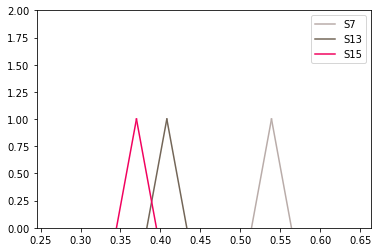

In [18]:
plot_tri(df_result3)